In [91]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard, LKV
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt

### Load model

In [92]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [93]:
t_span = (0, 15)
N = 256
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [94]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [95]:
x0, y0 = 1.75, 0.85

epsilon = 0.5
xi0 = (x0 - 1) / epsilon
eta0 = (y0 - 1) / epsilon

In [96]:
xi0, eta0

(1.5, -0.30000000000000004)

In [97]:
alpha_list = [0.2]
ic_list = [[xi0, eta0]]
epsilon_list = [epsilon]
p_list = [10]

In [98]:
xi0, eta0

(1.5, -0.30000000000000004)

## Lindstedt-Poincare method

In [99]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution_LKV(epsilon_list, p_list, ic_list, alpha_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

In [100]:
w_sol

[[np.float64(0.4472135954999579),
  np.float64(-0.001707956113528234),
  np.float64(-0.09915970260565002),
  np.float64(0.14407530048551107),
  np.float64(-0.18333170478406582),
  np.float64(0.1617506349971898),
  np.float64(-0.07816983172245129),
  np.float64(-0.016705402525008482),
  np.float64(-0.003093628807928477),
  np.float64(0.2764254840493592),
  np.float64(-0.7948908489249789)]]

In [101]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-10, check_divergence=False))

w_final_list

[[np.float64(0.4472135954999579),
  np.float64(0.4463596174431938),
  np.float64(0.4215696917917813),
  np.float64(0.43957910435247016),
  np.float64(0.42812087280346606),
  np.float64(0.43317558014712826),
  np.float64(0.43195417652646495),
  np.float64(0.43182366556923835),
  np.float64(0.43181158108170736),
  np.float64(0.43235147460524126),
  np.float64(0.43157521401058796)]]

In [102]:
#_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
#w_teor

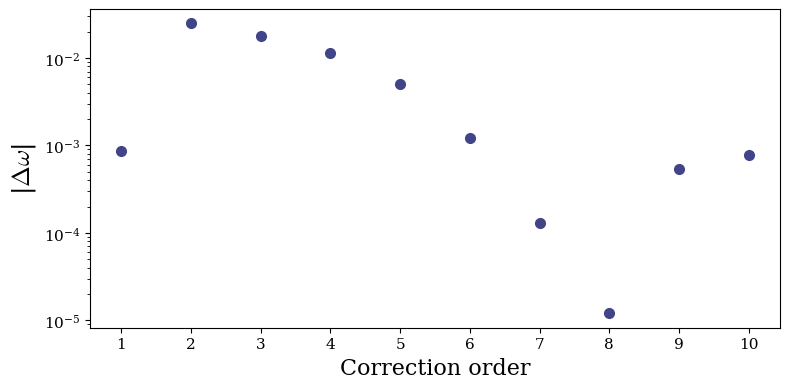

In [103]:
LPM.relative_error(w_final_list[0])
#LPM.w_absolute_error(w_final_list[0], w_teor)

In [104]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

In [105]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_lv_comparison(t_eval_lpm, t_eval_num, NN_TL_solution_LPM, x, y, epsilon_list):
    # --- Style settings ---
    label_fs  = 18
    tick_fs   = 14
    legend_fs = 14
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(12, 4.8))

    # --- Define consistent colors for (xi,x) and (eta,y) ---
    color_xi  = cm.viridis(0.15)  # i = 0
    color_eta = cm.viridis(0.55)  # i = 1

    # --- Numerical reference first (lighter colors) ---
    ax.plot(
        t_eval_num,
        x,
        label="$x$",
        color=color_xi,
        linewidth=2.0,
        alpha=0.7,
        zorder=1,
    )

    ax.plot(
        t_eval_num,
        y,
        label="$y$",
        color=color_eta,
        linewidth=2.0,
        alpha=0.7,
        zorder=1,
    )

    # --- PTL-PINN approximations last (bolder dashed lines) ---
    ax.plot(
        t_eval_lpm,
        1 + epsilon_list[0] * NN_TL_solution_LPM[:, 0],
        label=r"$1 + \varepsilon \xi$",
        color=color_xi,
        linewidth=2.4,
        linestyle=(0, (6, 3)),  # longer dashes
        marker="o",
        markersize=4.5,
        markevery=100,
        alpha=0.95,
        zorder=3,
    )

    ax.plot(
        t_eval_lpm,
        1 + epsilon_list[0] * NN_TL_solution_LPM[:, 1],
        label=r"$1 + \varepsilon \eta$",
        color=color_eta,
        linewidth=2.4,
        linestyle=(0, (6, 3)),  
        marker="s",
        markersize=4.5,
        markevery=100,
        alpha=0.95,
        zorder=3,
    )

    # --- Axis labels and ticks ---
    ax.set_xlabel("t", fontsize=label_fs, labelpad=6)
    ax.set_ylabel("Solution", fontsize=label_fs, labelpad=8)
    ax.tick_params(axis="both", labelsize=tick_fs)

    # --- Legend on top ---
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
        fontsize=legend_fs,
        frameon=False,
        handlelength=2.8,
        markerscale=1.2,
        labelspacing=0.4,
    )

    plt.tight_layout()
    plt.show()



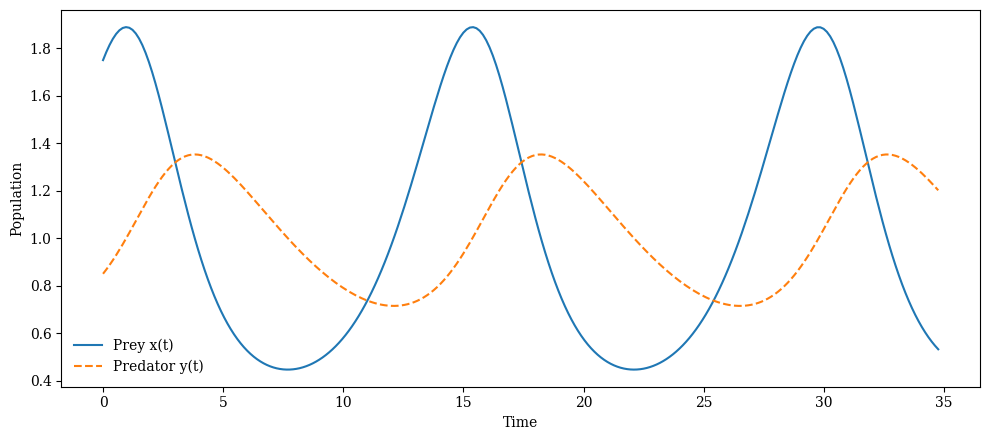

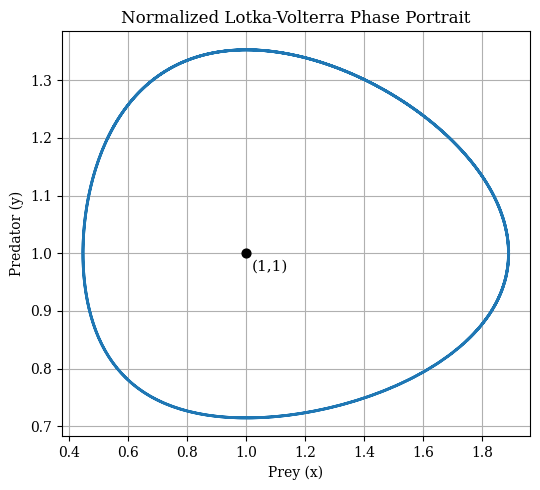

In [106]:
ode = equations.lv_normalized(alpha_list[0])
sol = numerical.solve_ode_equation(ode, (t_eval_lpm[0], t_eval_lpm[-1]), t_eval_lpm, [x0, y0])
x, y = sol

LKV.plot_numerical_LKV(x, y, t_eval_lpm)

/tmp/ipykernel_82238/3708410380.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


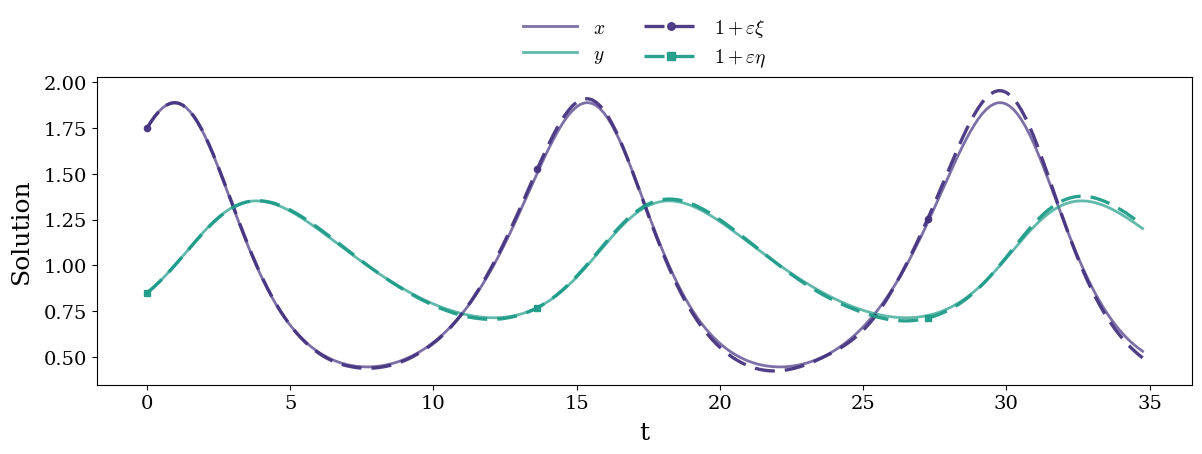

In [107]:
plot_lv_comparison(t_eval_lpm, t_eval_lpm, NN_TL_solution_LPM, x, y, epsilon_list)

In [108]:
np.mean(np.abs(y - 1 - epsilon * NN_TL_solution_LPM[:, 1]))

np.float64(0.008591239120649366)

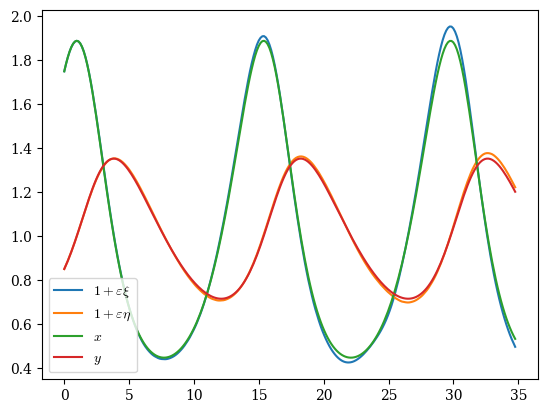

In [109]:
plt.plot(t_eval_lpm, 1 + epsilon_list[0] * NN_TL_solution_LPM[:, 0], label=r"$1 + \varepsilon \xi$")
plt.plot(t_eval_lpm, 1 + epsilon_list[0] * NN_TL_solution_LPM[:, 1], label=r"$1 + \varepsilon \eta$")
plt.plot(t_eval_lpm, x, label="$x$")
plt.plot(t_eval_lpm, y, label="$y$")
plt.legend()

In [110]:
perturbation_solution_LPM[0].shape

(256, 2)

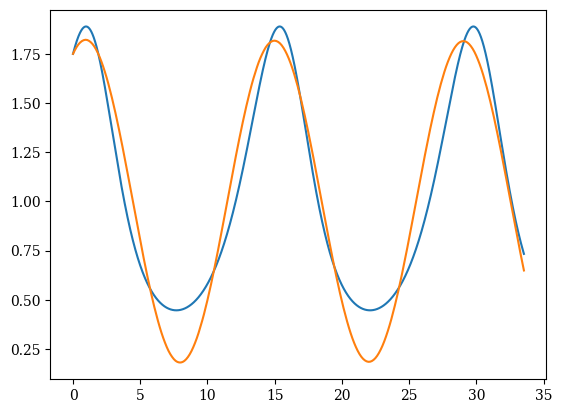

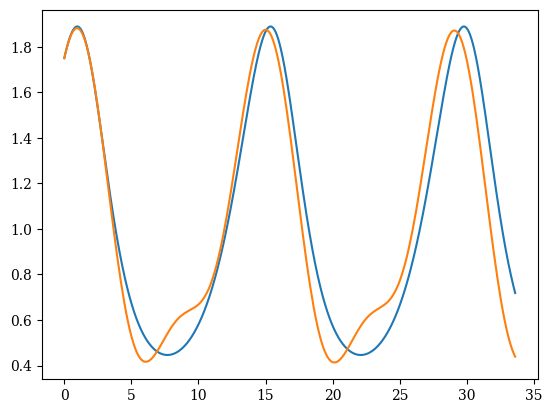

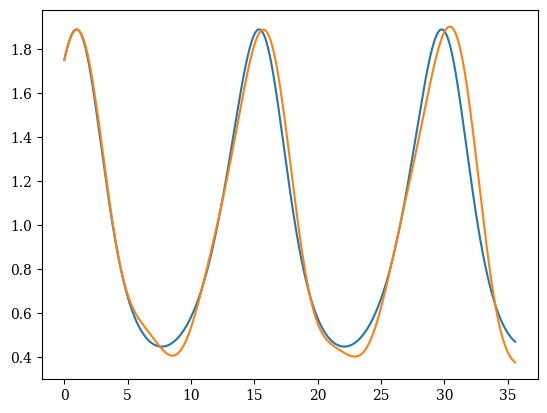

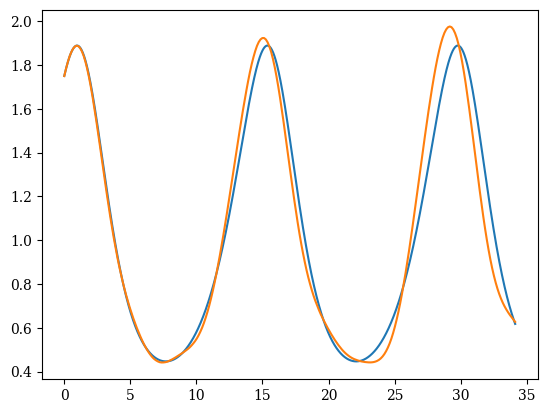

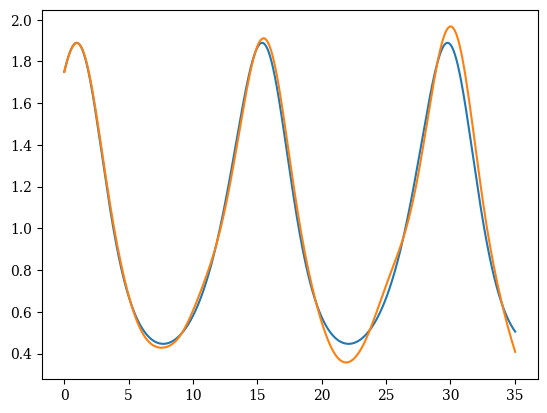

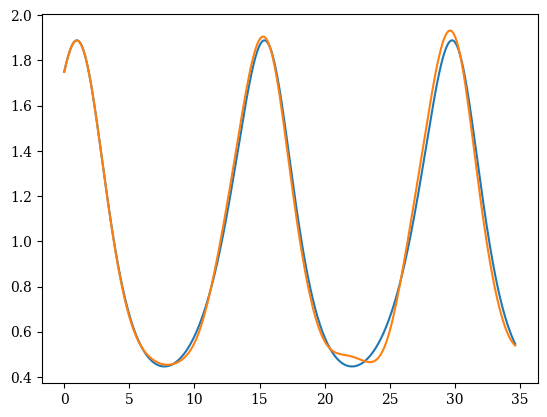

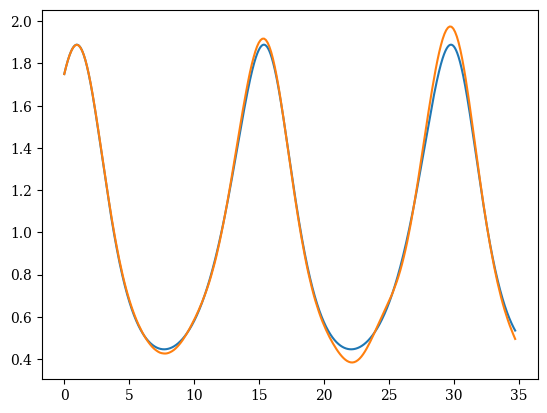

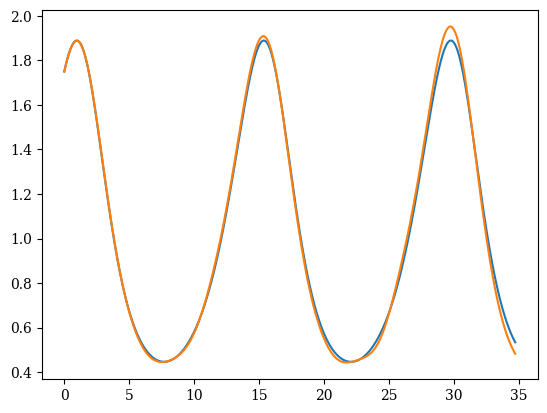

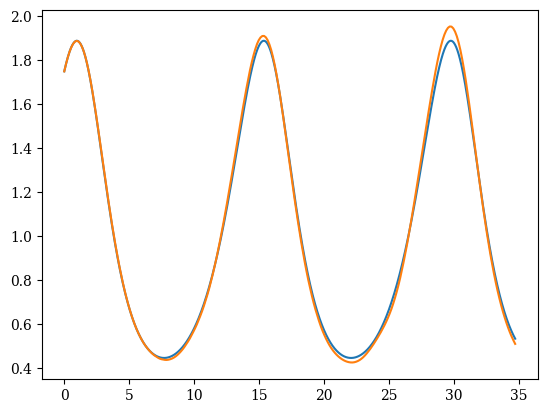

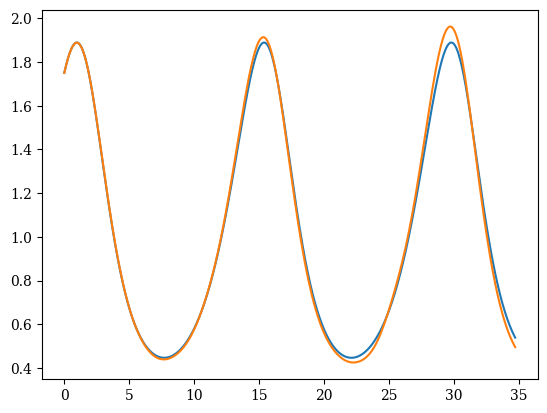

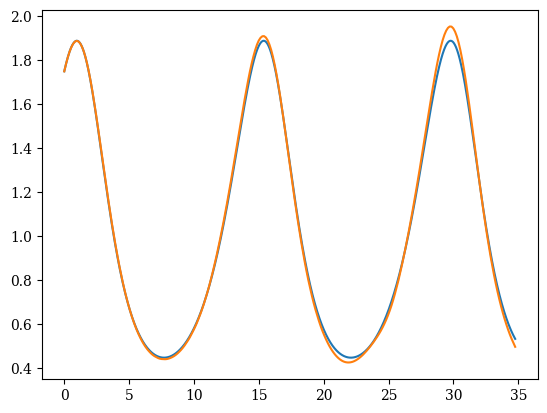

In [111]:
w_final = []
xi_final = []
error = []

for i in range(len(w_sol[0])):

    if i == 0:
        w_loop = np.sqrt(alpha_list[0])
        xi_loop = perturbation_solution_LPM[0][:, 0]
    else:
        w_loop = w_final[i - 1] + (epsilon ** i)  * w_sol[0][i]
        xi_loop  = xi_final[i - 1] + (epsilon ** i) * perturbation_solution_LPM[i][:, 0]

    w_final.append(w_loop)
    xi_final.append(xi_loop)

    t_span_loop = (0, t_span[-1]/w_loop)
    t_eval_loop_ptl = np.linspace(t_span_loop[0], t_span_loop[1], N)
    dt = (t_eval_loop_ptl[1] - t_eval_loop_ptl[0])/200
    t_eval_loop = np.linspace(t_span_loop[0], t_span_loop[1], (t_eval_loop_ptl.size - 1)*200 + 1)
    sol_loop = numerical.solve_ode_equation(ode, t_span_loop, t_eval_loop, [x0, y0])
    x_loop, y_loop = sol_loop 

    error.append(np.mean(np.abs(1 + epsilon * xi_loop - x_loop[::200])))

    plt.plot(t_eval_loop, x_loop)
    plt.plot(t_eval_loop_ptl, 1 + epsilon * xi_loop)
    plt.show()

In [112]:
error

[np.float64(0.13752938033548912),
 np.float64(0.1246107806760926),
 np.float64(0.05856317230758558),
 np.float64(0.06774601175066355),
 np.float64(0.03841996171720001),
 np.float64(0.030398691078522718),
 np.float64(0.020682455088339602),
 np.float64(0.01789340324657454),
 np.float64(0.017140528742571427),
 np.float64(0.020174720842713267),
 np.float64(0.01544113342608796)]